# Description
______

This script analyzes HYPE future climate and historical simulations as follows:
- The official Ouranos ESPO-G6-R2 v1.0.0 ensemble which includes 15 models with SSP2-4.5 and SSP3-7.0 for a total of 30 ensemble members is used.
- For each of the 30 members, the mean annual flow volume was calculated (sum of flow for each year then calculate the mean across each year) from 2015 to 2100.
- The models that are closest to the median, 75th percentile and 25th percentile of the mean annual flow volume at SMRIB and MREIB were selected from the 30 members (SSP2-4.5 and SSP3-7.0).
- The average annual hydrographs at both gauges are plotted

### Import Libraries

In [1]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import ParserError
import cycler
import matplotlib.ticker as ticker
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import matplotlib.gridspec as gridspec

### Inputs

In [2]:
# Results directory
results_directory = './renamed_results/'

# Start and end years for the future climate period
start_year= 2015
end_year= 2100

# HYPE output variable
variable= 'cout' 

# Path to HYPE output files
mreib_historical_path= '../../hds_model_v9/results/0058308.txt'
smrib_historical_path= '../../hds_model_v9/results/0058208.txt'

# Output directory for plots
output_directory= '../ijc_outputs/'

### Define Functions

In [3]:
def extract_ensemble(results_directory: str, subbasin_id: str, exclude_members=True):
    """
    Extracts ensemble data from files, filters by subbasin ID, and optionally excludes members not found in the offical ensemble.

    Parameters:
        results_directory (str): Path to the directory containing result files.
        subbasin_id (str): Identifier for filtering files belonging to a specific subbasin.
        exclude_members (bool): If True, excludes specified model members.

    Returns:
        xarray.DataArray: Combined ensemble data as an xarray DataArray.
    """
    # List of model names to exclude (not in official ensemble)
    exclude_models = [
        'CanESM5', 'CNRM-CM6-1', 'EC-Earth3', 'IPSL-CM6A-LR',
        'UKESM1-0-LL', 'NorESM2-MM', 'EC-Earth3-CC', 'NESM3',
        'EC-Earth3-Veg', 'INM-CM4-8', 'TaiESM1'
    ]
    
    # Check for files of required subbasin_id
    file_list = [os.path.join(results_directory, filename) for filename in os.listdir(results_directory)
                 if subbasin_id in filename]  # Only filter by subbasin_id
    
    # Create an empty list to store xarray DataArrays
    data_arrays: List[xr.DataArray] = []
    member_names = []  # To store the 'name' of each DataArray for concatenation

    # Loop through each file
    for file_path in file_list:
        # Extract the filename without extension to use as the member name
        member_name = os.path.splitext(os.path.basename(file_path))[0]

        # Conditionally exclude models if exclude_members is True
        if exclude_members and (any(excluded in member_name for excluded in exclude_models) or 'ssp585' in member_name):
            continue
        
        # Read the file into a pandas DataFrame
        df = pd.read_csv(file_path, sep='\t', index_col=0)

        # Drop the first row to remove units
        df = df.iloc[1:]

        # Convert the DataFrame to an xarray DataArray
        data_array = xr.DataArray(df.values, dims=('DATE', 'variable'),
                                  coords={'DATE': df.index, 'variable': df.columns})
        
        # Assign the filename as the name of the DataArray
        data_array.name = member_name
        
        # Append the DataArray to the list
        data_arrays.append(data_array)
        member_names.append(member_name)  # Keep track of the member name

    # Check if any valid data arrays exist
    if not data_arrays:
        return xr.DataArray()  # Return an empty DataArray if no valid members are left
    
    # Concatenate the list of DataArrays along dimension 'member'
    ds = xr.concat(data_arrays, dim='member')
    
    # Add the member names as a coordinate
    ds.coords['member'] = ('member', member_names)

    # Convert 'DATE' coordinate to datetime, specifying the format and handling errors
    ds['DATE'] = pd.to_datetime(ds['DATE'], format='%Y-%m-%d', errors='coerce')

    # Select the specified variable from the dataset
    var_data = ds.sel(variable='cout')
    
    return var_data

In [4]:
def find_mean_annual_vol(full_ensemble, start_year, end_year, gauge_name, output_directory):
    """
    Calculates the mean annual volume for the ensemble and returns results for the full official ensemble, ssp245 and ssp370 seperately. 
    
    Parameters:
        full_ensemble (xarray.DataArray): Data containing streamflow in the official ensemble
        start_year (int): Start year for filtering data 
        end_year (int): End year for filtering data 
        gauge_name (str): Name of the stream gauge for the plot title.
        output_directory (str): Directory to save the plot.
    """
    # Create an empty dictionary to store annual sums for each member
    annual_sums = {}

    # Seconds in a day for conversion
    seconds_per_day = 24 * 60 * 60  # 86,400 seconds in a day

    # Loop through each member in the dataset
    for member_name in full_ensemble.member.values:
        # Select the member data
        member_data = full_ensemble.sel(member=member_name)
        
        # Ensure numeric conversion if data is stored as strings
        if member_data.dtype == object:
            member_data = member_data.astype(float)
        
        # Convert the DataArray to a DataFrame with DATE as the index
        member_df = member_data.to_dataframe(name='cout').reset_index()
        
        # Extract the year and month from the DATE column
        member_df['Year'] = member_df['DATE'].dt.year
        member_df['Month'] = member_df['DATE'].dt.month
        
        # # Filter the DataFrame to include only rows between April 1st and September 30th
        # filtered_df = member_df[
        #     (member_df['DATE'].dt.month >= 4) & (member_df['DATE'].dt.month <= 10)
        # ].copy()
        
        # Convert daily flow rate (m³/s) to total daily volume (m³) by multiplying by the number of seconds in a day
        member_df['Daily_Volume_m3'] = member_df['cout'] * seconds_per_day
        
        # Group by year and calculate the annual sum of daily volumes
        annual_sum = member_df.groupby('Year')['Daily_Volume_m3'].sum()
        
        # Add the annual sum to the dictionary
        annual_sums[member_name] = annual_sum

    # Combine all annual sums into a single DataFrame
    annual_sums_df = pd.DataFrame(annual_sums)

    # Filter the DataFrame to include only rows where Year is between start_year and end_year
    filtered_annual_sums_df = annual_sums_df[(annual_sums_df.index >= start_year) & (annual_sums_df.index <= end_year)]

    # Sort DataFrame columns by member for consistency
    filtered_annual_sums_df = filtered_annual_sums_df.sort_index(axis=1)

    # Calculate the mean across all years for each member and sort in descending order
    total_mean_df = filtered_annual_sums_df.mean().sort_values(ascending=False).to_frame(name='Mean')
    total_mean_df.index.name = 'Member'

    # Split the DataFrame into two based on column names containing "ssp245" and "ssp370"
    ssp245_df = filtered_annual_sums_df.filter(like='ssp245')
    ssp370_df = filtered_annual_sums_df.filter(like='ssp370')

    # Calculate the mean of the columns for each DataFrame
    ssp245_mean = ssp245_df.mean()
    ssp370_mean= ssp370_df.mean()

    # Convert column means to DataFrames, sort them in descending order, and set the index name to "Member"
    ssp245_mean = ssp245_mean.sort_values(ascending=False).to_frame(name='Mean')
    ssp245_mean.index.name = 'Member'

    ssp370_mean = ssp370_mean.sort_values(ascending=False).to_frame(name='Mean')
    ssp370_mean.index.name = 'Member'

    return total_mean_df, ssp245_mean, ssp370_mean

In [5]:
def ensemble_boxplot(output_directory, start_year, end_year, **dataframes):
    """
    Create a box plot with each DataFrame as a group on the x-axis, along with separate subplots for merib and smrib.

    Parameters:
        output_directory (str): Directory to save the plot.
        start_year (int): Start year for the plot title.
        end_year (int): End year for the plot title.
        **dataframes: DataFrames with columns 'Sum'. Keys will be used as x-axis labels.
    """
    # Extract data and labels
    data = [df['Mean'].values for df in dataframes.values()]
    labels = list(dataframes.keys())

    # Separate merib and smrib data
    mreib_data = [df['Mean'].values for name, df in dataframes.items() if 'mreib' in name.lower()]
    smrib_data = [df['Mean'].values for name, df in dataframes.items() if 'smrib' in name.lower()]

    # Extract relevant part of the name after the underscore
    mreib_labels = [name.split('_')[-1] for name in dataframes.keys() if 'mreib' in name.lower()]
    smrib_labels = [name.split('_')[-1] for name in dataframes.keys() if 'smrib' in name.lower()]

    # Create the figure and grid layout
    fig = plt.figure(figsize=(14, 8))
    spec = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[3, 1], height_ratios=[1, 1], figure=fig)

    # Main box plot (spans two rows in the left column)
    main_ax = fig.add_subplot(spec[:, 0])
    main_ax.boxplot(data, tick_labels=labels, patch_artist=True, boxprops=dict(facecolor="lightblue", color="black"),
                   medianprops=dict(color="black", linewidth=1))  # Set median line to black
    main_ax.set_xlabel("Location and Scenario/Ensemble")
    main_ax.set_ylabel("Average Annual Streamflow Volume (m³/year)")
    main_ax.set_title(f'Average Annual Streamflow Volume from {start_year} to {end_year}')
    main_ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Subplot for smrib (top right)
    smrib_ax = fig.add_subplot(spec[0, 1])
    if smrib_data:
        smrib_ax.boxplot(smrib_data, tick_labels=smrib_labels, patch_artist=True, boxprops=dict(facecolor="lightcoral", color="black"),
                         medianprops=dict(color="black", linewidth=1))  # Set median line to black
        smrib_ax.set_title("SMRIB")
        smrib_ax.grid(axis="y", linestyle="--", alpha=0.7)
      #  smrib_ax.set_xlabel("Scenario")

    # Subplot for mreib (bottom right)
    mreib_ax = fig.add_subplot(spec[1, 1])
    if mreib_data:
        mreib_ax.boxplot(mreib_data, tick_labels=mreib_labels, patch_artist=True, boxprops=dict(facecolor="lightgreen", color="black"),
                         medianprops=dict(color="black", linewidth=1))  # Set median line to black
        mreib_ax.set_title("MREIB")
        mreib_ax.grid(axis="y", linestyle="--", alpha=0.7)
        mreib_ax.set_xlabel("Scenario/Ensemble")
        
    # Adjust layout
    plt.tight_layout()

    # Save the plot to the output directory
    output_path = os.path.join(output_directory, 'total_volume_boxplot.png')
    plt.savefig(output_path, bbox_inches="tight")
    plt.show()

In [6]:
def get_min_max_med(stm, milk):
    """
    Given two DataFrames (`stm` and `milk`), calculates the indexes that minimize
    the sum of normalized distances from the 75th, 25th, and median percentiles of the 'Sum' column
    in both DataFrames.

    Parameters:
        stm (pd.DataFrame): Dataframe with SMRIB data.
        milk (pd.DataFrame): Dataframe with MREIB data.

    Returns:
        pd.DataFrame: A DataFrame with the closest members for the 75th percentile, 25th percentile,
                      and median.
    """
    # Function to calculate the closest member for a given value
    def calculate_closest(value_stm, value_milk, stm, milk):
        stm_copy = stm[['Mean']].copy()
        milk_copy = milk[['Mean']].copy()

        # Calculate normalized distances
        stm_copy['normalized_distance'] = (stm_copy['Mean'] - value_stm).abs() / abs(value_stm)
        milk_copy['normalized_distance'] = (milk_copy['Mean'] - value_milk).abs() / abs(value_milk)

        # Modify the indexes of the copies by dropping the second term so they match
        stm_copy.index = stm_copy.index.str.replace(r'^([^_]+)_[^_]+_(.*)$', r'\1_\2', regex=True)
        milk_copy.index = milk_copy.index.str.replace(r'^([^_]+)_[^_]+_(.*)$', r'\1_\2', regex=True)

        # Merge DataFrames
        merged = pd.merge(
            stm_copy[['normalized_distance']],
            milk_copy[['normalized_distance']],
            left_index=True,
            right_index=True,
            suffixes=('_stm', '_milk')
        )

        # Calculate the sum of normalized distances
        merged['distance_sum'] = merged['normalized_distance_stm'] + merged['normalized_distance_milk']

        # Find the closest index and corresponding distance_sum value
        closest_index = merged['distance_sum'].idxmin()
        distance_sum_value = merged.loc[closest_index, 'distance_sum']

        return closest_index #, distance_sum_value

    # Calculate 75th percentile, 25th percentile, and median for both locations
    metrics = {
        '75th_percentile': (stm['Mean'].quantile(0.75), milk['Mean'].quantile(0.75)),
        'median': (stm['Mean'].median(), milk['Mean'].median()),
        '25th_percentile': (stm['Mean'].quantile(0.25), milk['Mean'].quantile(0.25))
    }

    # Find the closest member for each metric across gauges
    results = {
        metric: calculate_closest(value_stm, value_milk, stm, milk)
        for metric, (value_stm, value_milk) in metrics.items()
    }

    # # Convert results to a DataFrame with Total Distance from Metricr col (optional)
    # result_df = pd.DataFrame.from_dict(
    #     {metric: {'Best Matching Member': idx, 'Total Distance from Metric': diff} for metric, (idx, diff) in results.items()},
    #     orient='index'
    # )

    # Convert results to a DataFrame 
    result_df = pd.DataFrame.from_dict(
        {metric: {'Best Matching Member': idx} for metric, idx in results.items()},
        orient='index'
    )

    output_path = os.path.join(output_directory, 'best_fitting_members.csv')
    result_df.to_csv(output_path)

    return result_df

In [7]:
def process_average_annual_ensemble(results_directory: str, 
                     subbasin_id: str, 
                     scenario: str, 
                     start_year: int, 
                     end_year: int, 
                     variable: str) -> xr.DataArray:
    """
    Processes ensemble data for a specified subbasin, scenario, and variable, 
    filtering by start and end year, and calculates average annual runoff.

    Parameters:
        results_directory (str): Directory containing the ensemble files.
        subbasin_id (str): Subbasin ID to filter the files.
        scenario (str): Scenario identifier to filter the files.
        start_year (int): Start year for filtering data.
        end_year (int): End year for filtering data.
        variable (str): Variable name to select from the dataset.

    Returns:
        xr.DataArray: Processed average annual runoff shifted to start on October 1st.
    """
    # List of member names to exclude
    exclude_members = [
        "CanESM5", "CNRM-CM6-1", "EC-Earth3", "IPSL-CM6A-LR", "UKESM1-0-LL",
        "NorESM2-MM", "EC-Earth3-CC", "NESM3", "EC-Earth3-Veg", "INM-CM4-8", "TaiESM1"
    ]
    
    # Check for files of required subbasin and scenario
    file_list = [os.path.join(results_directory, filename) 
                 for filename in os.listdir(results_directory) 
                 if (subbasin_id in filename) and (scenario in filename)]
    
    # Create an empty list to store xarray DataArrays
    data_arrays: List[xr.DataArray] = []

    # Loop through each file
    for file_path in file_list:
        # Skip files with excluded member names
        if any(member in file_path for member in exclude_members):
            continue
        
        # Read the file into a pandas DataFrame
        df = pd.read_csv(file_path, sep='\t', index_col=0)

        # Drop the first row
        df = df.iloc[1:]

        # Convert the DataFrame to an xarray DataArray
        data_array = xr.DataArray(df.values, dims=('DATE', 'variable'), coords={'DATE': df.index, 'variable': df.columns})

        # Append the DataArray to the list
        data_arrays.append(data_array)

    # Concatenate the list of DataArrays along a new dimension 'member'
    ds = xr.concat(data_arrays, dim='member')

    # Convert 'DATE' coordinate to datetime, specifying the format and handling errors
    ds['DATE'] = pd.to_datetime(ds['DATE'], format='%Y-%m-%d', errors='coerce')

    # Convert 'member' coordinate to float
    ds = ds.astype(float)

    # Select the specified variable from the dataset
    var_data = ds.sel(variable=variable)

    # Sort the dataset along the 'DATE' coordinate
    var_data = var_data.sortby('DATE')

    # Filter the sorted dataset to include only data between the specified years
    var_data = var_data.sel(DATE=(var_data['DATE'].dt.year >= start_year) & (var_data['DATE'].dt.year <= end_year))

    # Calculate the mean of these daily means for each member to get the average annual runoff
    average_annual_runoff = var_data.groupby('DATE.dayofyear').mean(dim='DATE')

    # Drop leap day (dayofyear = 366)
    average_annual_runoff = average_annual_runoff.sel(dayofyear=~(average_annual_runoff['dayofyear'] == 366))
    
    # Shift data to start on October 1st
    dayofyear_shifted = ((average_annual_runoff['dayofyear'] - 274) % 365) + 1

    # Update the 'dayofyear' coordinate with the shifted values
    average_annual_runoff['dayofyear'] = dayofyear_shifted

    # Sort the data_array along the 'dayofyear' coordinate
    average_annual_runoff_shifted = average_annual_runoff.sortby('dayofyear')
    
    return average_annual_runoff_shifted

In [8]:
def process_historical(filepath: str, variable: str, start_date: str = '1981-01-01', end_date: str = '2015-12-31') -> pd.Series:
    """
    Processes historical data from HYPE output files into an average annual timeseries

    Parameters:
        filepath (str): Path to the HYPE output file.
        variable (str): The variable name in the file to process.
        start_date (str): The start date for the data filter (default is '1981-01-01').
        end_date (str): The end date for the data filter (default is '2015-12-31').

    Returns:
        pd.Series: A pandas Series with the historical average annual timeseries
    """
    
    # Read the tab-separated text file into a DataFrame
    sim: pd.DataFrame = pd.read_csv(filepath, delimiter='\t', index_col=0)
    
    # Drop the first row
    sim = sim.iloc[1:]
    
    # Drop all columns except for 'variable'
    sim = sim[[variable]]
    
    # Convert index to datetime
    sim.index = pd.to_datetime(sim.index)
    
    # Trim the DataFrame between dates
    sim = sim.loc[start_date:end_date]
    
    # Get the length of the DataFrame before dropping NaN values
    original_length: int = len(sim)
    
    # Convert the 'variable' column to numeric
    sim[variable] = pd.to_numeric(sim[variable], errors='coerce')
    
    # Drop NaN values if any
    sim = sim.dropna()
    
    # Get the length of the DataFrame after dropping NaN values
    new_length: int = len(sim)
    
    # Check if any NaN values were replaced
    if new_length < original_length:
        print("NaN values were replaced during conversion.")

    # Resample the data to calculate the mean for each day of the year across all years
    sim_resampled: pd.Series = sim.groupby(sim.index.dayofyear)[variable].mean()

    # Drop leap day (dayofyear = 366) if it exists to be consistent with future climate members
    sim_resampled = sim_resampled[sim_resampled.index != 366]

    # Shift dayofyear to start on October 1st and wrap around
    dayofyear_shifted = ((sim_resampled.index - 274) % 365) + 1

    # Update the index of the Series with the shifted dayofyear values
    sim_resampled.index = dayofyear_shifted

    # Sort the Series by index to ensure the correct order
    sim_shifted = sim_resampled.sort_index()
    
    return sim_shifted

In [9]:
def average_annual_plot(ens1: xr.DataArray, ens2: xr.DataArray, 
                        historical: pd.DataFrame, gauge_name: str, 
                        ens1_label: str, ens2_label: str, 
                        historical_label: str, start_year: int, end_year: int, 
                        var_name: str, output_directory: str):
    """
    Plots the average annual values for two future ensembles and a historical dataset. 
    The plot includes shaded areas representing the range of each ensemble, 
    the mean of the ensembles, and the historical trace.

    Parameters:
        ens1 (xr.DataArray): First future ensemble dataset with 'dayofyear' and 'member' dimensions.
        ens2 (xr.DataArray): Second future ensemble dataset with 'dayofyear' and 'member' dimensions.
        historical (pd.DataFrame): Historical data with 'dayofyear' as index.
        gauge_name (str): Name of the gauge for the plot title.
        ens1_label (str): Label for the first ensemble in the legend.
        ens2_label (str): Label for the second ensemble in the legend.
        historical_label (str): Label for the historical dataset in the legend.
        start_year (int): Start year for the analysis.
        end_year (int): End year for the analysis.
        var_name (str): Variable name for y-axis label.
        output_directory (str): Directory to save the output plot.

    Returns:
        None
    """
    # Set the figure size
    plt.figure(figsize=(16, 8))  # Adjust width and height as needed

    # Plot the historical trace
    historical.plot(label=historical_label, color='red')

    # Fill between lines for ens1
    plt.fill_between(
        ens1['dayofyear'],
        ens1.min(dim='member'),
        ens1.max(dim='member'),
        color='indigo',
        alpha=0.2
    )

    # Fill between lines for ens2
    plt.fill_between(
        ens2['dayofyear'],
        ens2.min(dim='member'),
        ens2.max(dim='member'),
        color='blue',
        alpha=0.2
    )

    # Calculate and plot the mean of each ensemble
    ens1_mean = ens1.mean(dim='member')
    ens2_mean = ens2.mean(dim='member')

    ens1_mean.plot(color='indigo', linestyle='-', label=ens1_label)
    ens2_mean.plot(color='blue', linestyle='-', label=ens2_label)

    # Manually create legend handles and labels
    legend_handles = [
        Patch(facecolor='indigo', alpha=0.2, label=ens1_label),
        Patch(facecolor='blue', alpha=0.2, label=ens2_label),
        Line2D([0], [0], color='indigo', lw=2, linestyle='-', label=f'{ens1_label} Mean'),
        Line2D([0], [0], color='blue', lw=2, linestyle='-', label=f'{ens2_label} Mean'),
        Line2D([0], [0], color='red', lw=2, label=historical_label)
    ]

    # Add legend with custom handles and labels
    plt.legend(handles=legend_handles)

    # Customize labels and title
    plt.xlabel('Day of Year (Starting Oct 1st)')
    plt.ylabel(f'Average Daily {var_name}')
    plt.title(f'{gauge_name} Average Daily {var_name} Between {start_year} and {end_year} for Official Ensemble')

    # Save the plot to the output directory
    file_path_allssp = os.path.join(output_directory, f'{gauge_name}_{start_year}_average_annual.png')
    plt.savefig(file_path_allssp)

    plt.show()


### Find Members

In [10]:
# Extract the offical ensembles
milk_official_ensemble= extract_ensemble(results_directory, '58308', True)
stm_official_ensemble= extract_ensemble(results_directory, '58208', True)

In [11]:
# Calculate the mean annual volume for each ensemble member in each scenario/location
milk_official, milk_ssp245, milk_ssp370= find_mean_annual_vol(milk_official_ensemble, start_year, end_year, 'MREIB', output_directory)
stm_official, stm_ssp245, stm_ssp370= find_mean_annual_vol(stm_official_ensemble, start_year, end_year, 'SMRIB', output_directory)

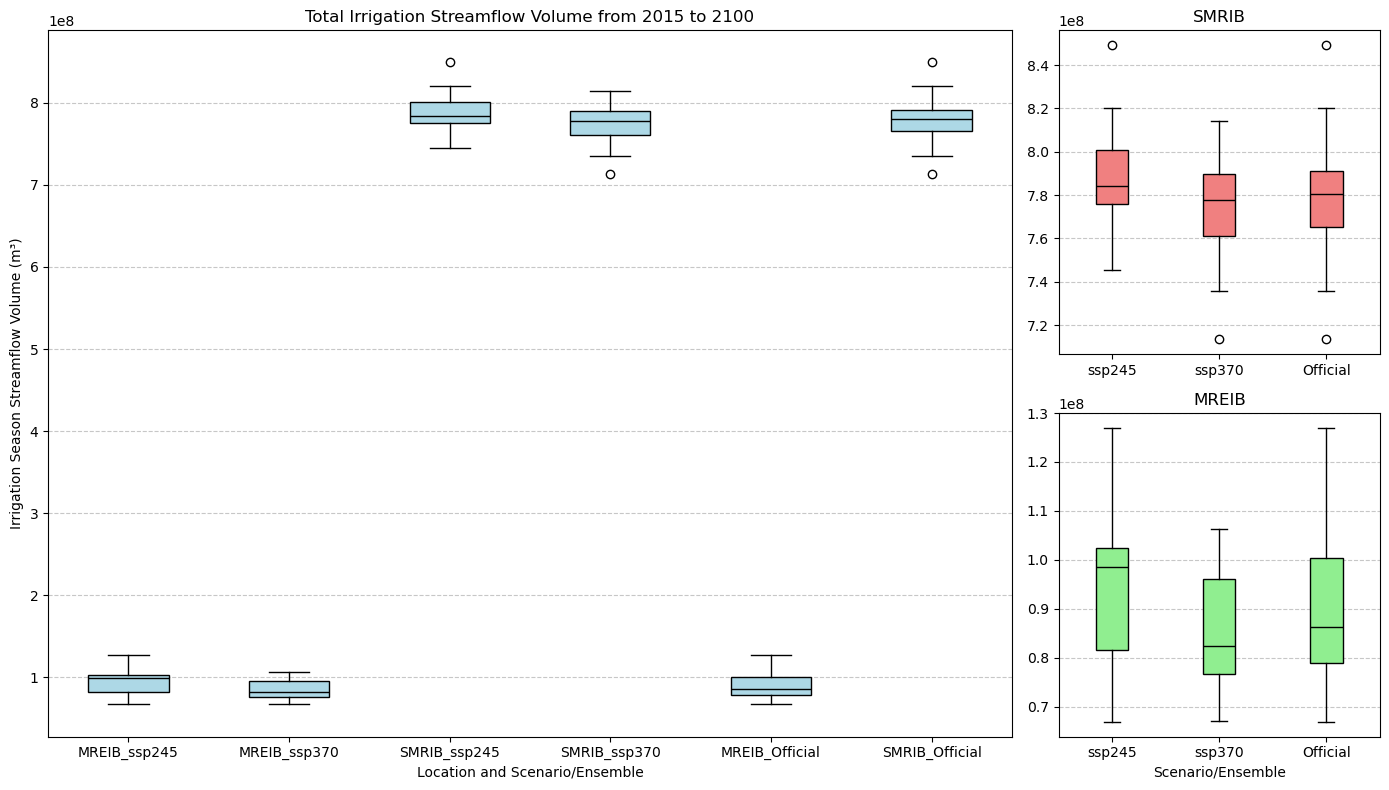

In [12]:
# Create the boxplot for each group of members
ensemble_boxplot(
    output_directory,
    start_year,
    end_year,
    MREIB_ssp245=milk_ssp245,
    MREIB_ssp370=milk_ssp370,
    SMRIB_ssp245=stm_ssp245,
    SMRIB_ssp370=stm_ssp370,
    MREIB_Official= milk_official,
    SMRIB_Official= stm_official
)

In [13]:
# Get members matching 75th, med and 25th percentiles for all groups of members
ssp245= get_min_max_med(milk_ssp245, stm_ssp245)
ssp370= get_min_max_med(milk_ssp370, stm_ssp370)
combined_official= get_min_max_med(milk_official, stm_official)

In [14]:
# Visualize the final choice of ensemble members coming from full official ensemble (combining ssp245 and 370)
combined_official

,Best Matching Member
75th_percentile,05_INM_INM-CM5-0_ssp245_r1i1p1f1_day
median,03_INM_INM-CM5-0_ssp370_r1i1p1f1_day
25th_percentile,50_MIROC_MIROC-ES2L_ssp370_r1i1p1f2_day


### Average Annual Plots

In [15]:
# Create averate annual data for MREIB ssp245
mreib_ssp245= process_average_annual_ensemble(results_directory, '58308', 'ssp245', start_year, end_year, variable)

In [16]:
# Create averate annual data for MREIB ssp370
mreib_ssp370 = process_average_annual_ensemble(results_directory, '58308', 'ssp370', start_year, end_year, variable)

In [17]:
# Create averate annual data for SMRIB ssp245
smrib_ssp245 = process_average_annual_ensemble(results_directory, '58208', 'ssp245', start_year, end_year, variable)

In [18]:
# Create averate annual data for SMRIB ssp370
smrib_ssp370 = process_average_annual_ensemble(results_directory, '58208', 'ssp370', start_year, end_year, variable)

In [19]:
# Extract historical data for SMRIB and MREIB
mreib_historical= process_historical(mreib_historical_path, variable, start_date="1981-01-01", end_date="2015-12-31")
smrib_historical= process_historical(smrib_historical_path, variable, start_date="1981-01-01", end_date="2015-12-31")

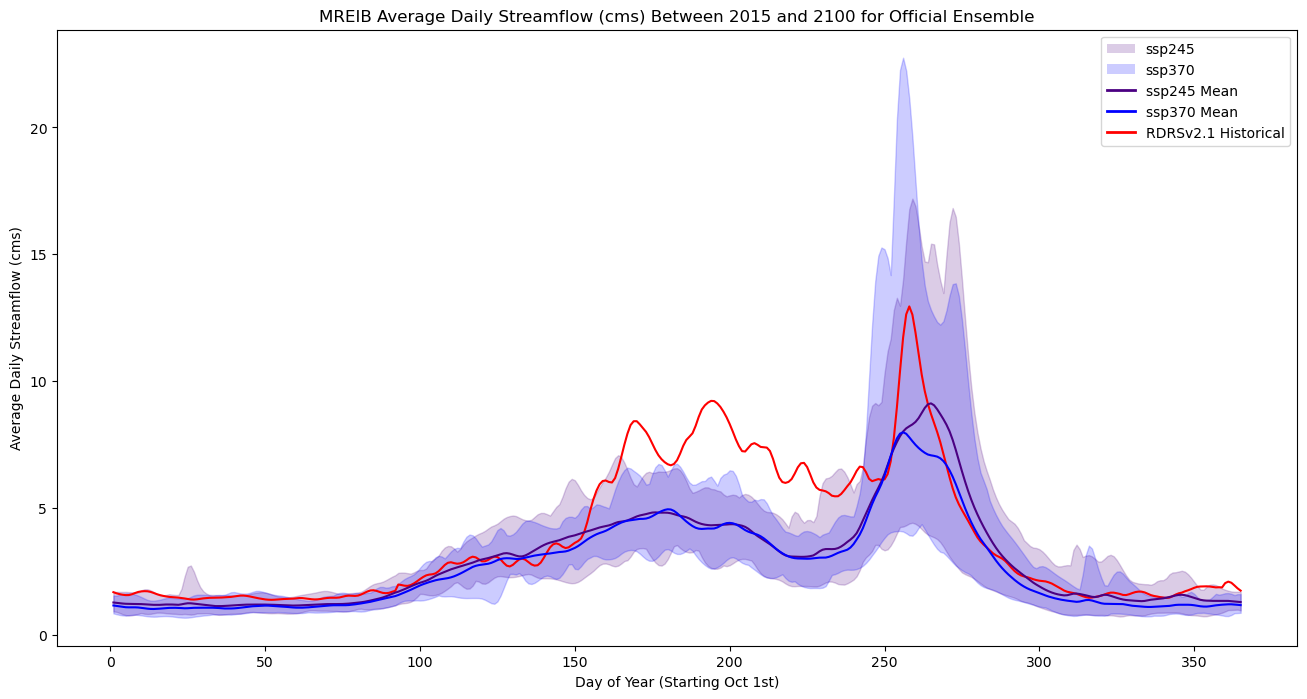

In [20]:
# MREIB average annual plot
average_annual_plot(mreib_ssp245, mreib_ssp370, mreib_historical, 'MREIB', 'ssp245', 'ssp370', 
                    'RDRSv2.1 Historical', start_year, end_year, 'Streamflow (cms)', output_directory)

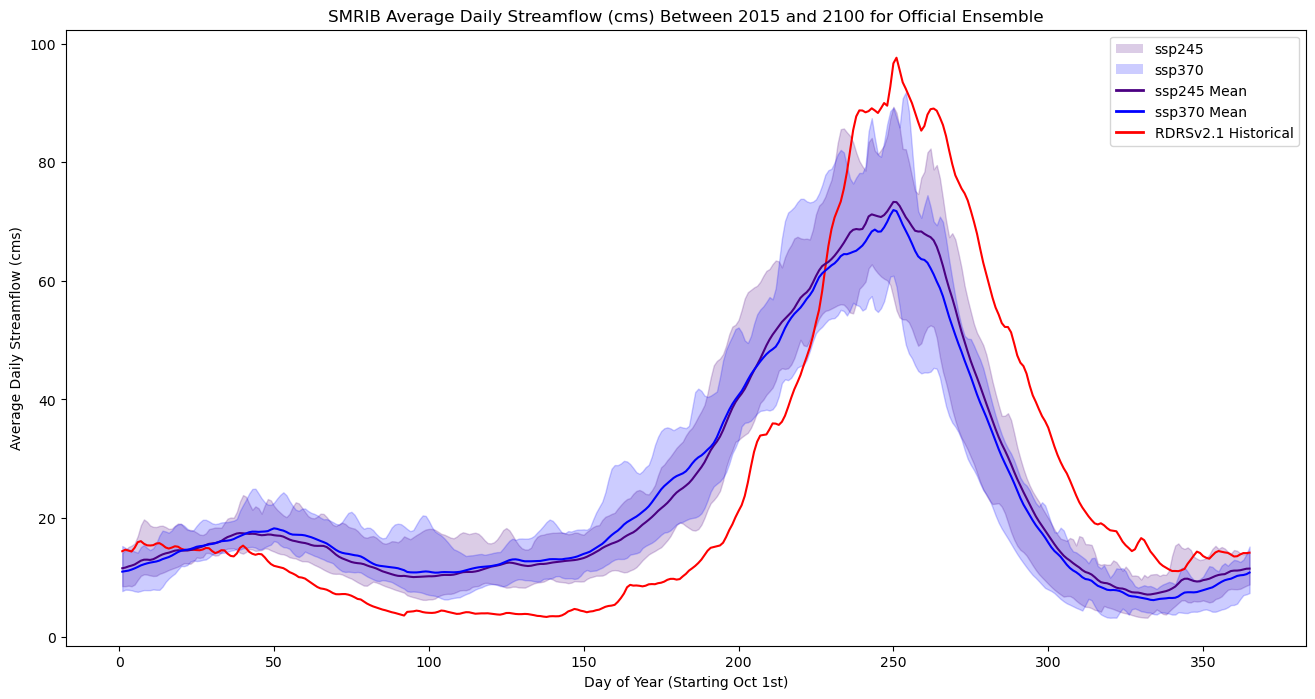

In [21]:
# SMRIB average annual plot
average_annual_plot(smrib_ssp245, smrib_ssp370, smrib_historical, 'SMRIB', 'ssp245', 'ssp370', 
                    'RDRSv2.1 Historical', start_year, end_year, 'Streamflow (cms)', output_directory)